In [808]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from statsmodels.tools.tools import add_constant
from arch import arch_model

In [809]:
main_df = pd.read_csv("../clean_data/main_df_clean.csv")
main_df["Time"] = main_df["Date"]
main_df["Time"] = main_df["Time"].astype(str)
main_df.set_index("Time",inplace=True)
main_df = main_df.drop(columns=["Date"])
main_df

,brl Exchange Rate,vnd Exchange Rate,hnl Exchange Rate,idr Exchange Rate,Coffee,Milk,Sugar,Tea,cop Exchange Rate,Negative_News_Ratio,...,Honduras_wind_speed_10m_max_hon,Honduras_wind_gusts_10m_max_hon,Honduras_et0_fao_evapotranspiration_hon,Indonesia_temperature_2m_mean_in,Indonesia_daylight_duration_in,Indonesia_sunshine_duration_in,Indonesia_precipitation_sum_in,Indonesia_wind_speed_10m_max_in,Indonesia_wind_gusts_10m_max_in,Indonesia_et0_fao_evapotranspiration_in
Time,,,,,,,,,,,,,,,,,,,,,
1990-01,0.000006,5479.329529,2.0000,1804.850000,0.758300,0.070170,0.142000,1.147273,440.08,0.158372,...,10.069539,31.134193,3.320075,25.252577,12.287324,8.420801,6.867742,12.574532,32.876128,3.412106
1990-02,0.000010,5479.329529,2.0000,1809.870000,0.840100,0.074822,0.146500,0.958396,451.72,0.159264,...,10.732204,30.805714,3.872699,25.438890,12.215222,9.179367,8.982143,9.290742,24.480000,3.518966
1990-03,0.000016,5479.329529,4.0000,1820.350000,0.939600,0.074173,0.153100,0.873620,463.40,0.160195,...,11.773626,34.803870,4.214509,25.706005,12.125023,9.753625,9.561290,8.809619,24.607741,3.814265
1990-04,0.000021,5479.329529,4.0000,1826.050000,0.937300,0.077387,0.152400,0.883644,474.62,0.161169,...,11.712375,34.319999,4.871768,26.231305,12.035547,9.697712,6.286667,7.469806,20.340000,3.766648
1990-05,0.000023,5563.430866,4.2000,1831.400000,0.920200,0.088704,0.146200,0.848309,485.99,0.162188,...,10.483667,32.736774,4.842873,26.307215,11.964987,9.630981,5.732258,7.962735,22.389677,3.583512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07,5.541448,24251.560000,24.8582,16261.652826,2.570987,0.242129,0.193517,1.363518,4036.80,0.065923,...,15.246755,35.698063,4.118606,26.897843,11.948145,10.162547,3.645161,12.121012,28.834838,4.220664
2024-08,5.552014,24245.850000,24.8826,15793.181818,2.614377,0.244700,0.184195,1.467152,4062.98,0.065906,...,15.815804,37.312257,4.518683,28.485544,12.008544,10.225594,1.296774,14.199244,34.281289,4.954863
2024-09,5.540967,24163.540000,24.8381,15341.250000,2.787605,0.251466,0.206248,1.572990,4191.86,0.065879,...,11.425362,28.991999,4.216293,27.723999,12.092080,9.381017,6.356667,12.624396,28.259999,4.434608


In [810]:
result = adfuller(main_df["Coffee"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -1.7881037924831735
P-Value: 0.3863836197218491


In [811]:
main_df["coffee_diff"] = main_df["Coffee"].diff()

main_df["coffee_diff"] = main_df["coffee_diff"].replace([np.inf, -np.inf], np.nan)

main_df = main_df.dropna(subset=["coffee_diff"])

In [812]:
result = adfuller(main_df["coffee_diff"])
print(f"ADF Statistic: {result[0]}")
print(f"P-Value: {result[1]}")

ADF Statistic: -11.585252397836792
P-Value: 2.877944863970424e-21


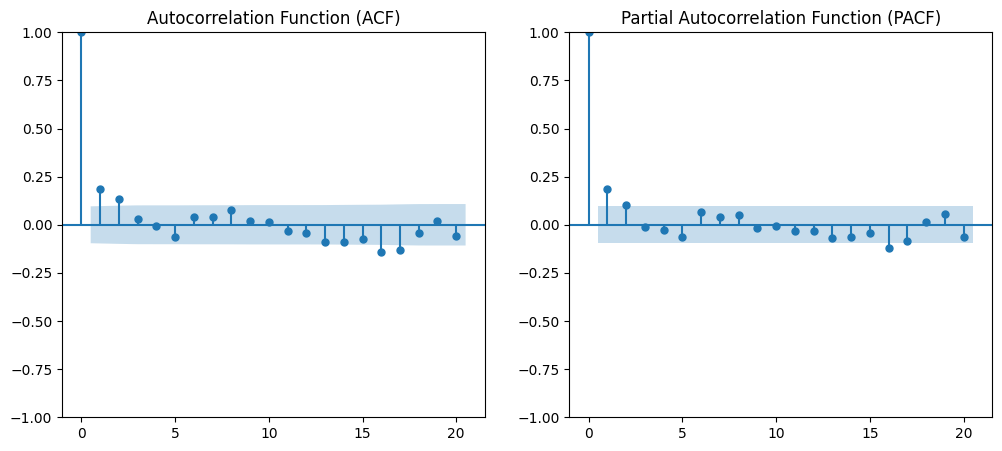

In [813]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

plot_acf(main_df["coffee_diff"], lags=20, ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(main_df["coffee_diff"], lags=20, ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

<div align="center">
  ARMA(1,1) Model
</div>

In [814]:
train_size = int(len(main_df) * 0.8)
train_data = main_df['coffee_diff'][:train_size]
test_data = main_df['coffee_diff'][train_size:]

model = ARIMA(train_data, order=(1, 1, 1))
fitted_model = model.fit()

train_predictions = fitted_model.fittedvalues
test_predictions = fitted_model.forecast(steps=len(test_data))

train_mse = mean_squared_error(train_data[1:], train_predictions[1:])
test_mse = mean_squared_error(test_data, test_predictions)

predicted_returns = np.concatenate([train_predictions, test_predictions])

cumulative_predicted_returns = np.cumsum(predicted_returns)

main_df["coffee_price_change"] = main_df["coffee_diff"].cumsum()

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3161666900.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

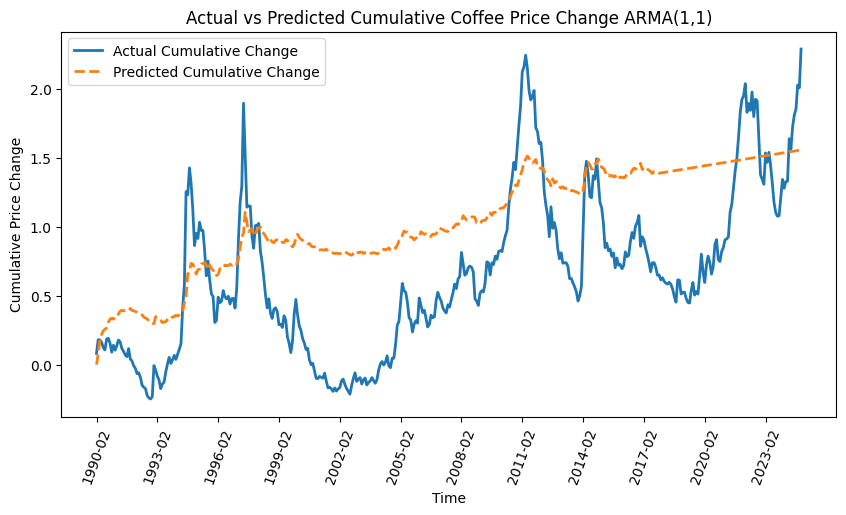

In [815]:
plt.figure(figsize=(10,5))
plt.plot(main_df.index, main_df["coffee_price_change"], label="Actual Cumulative Change", linewidth=2)
plt.plot(main_df.index, cumulative_predicted_returns, label="Predicted Cumulative Change", linestyle="dashed", linewidth=2)
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(main_df), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Cumulative Price Change")
plt.title("Actual vs Predicted Cumulative Coffee Price Change ARMA(1,1)")

plt.show()

In [816]:
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.011349332510037242
Test MSE: 0.012236437888166862


<div align="center">
  GARCH(1,1) Model
</div>

In [817]:
train_size = int(len(main_df) * 0.8)
train_returns = main_df['coffee_diff'][:train_size].dropna()
test_returns = main_df['coffee_diff'][train_size:].dropna()

garch_model = arch_model(train_returns, vol="Garch", p=1, q=1)
garch_result = garch_model.fit(disp="off")

train_predicted_volatility = garch_result.conditional_volatility

X_train = sm.add_constant(train_predicted_volatility)
y_train = train_returns

garch_m_reg = sm.OLS(y_train, X_train).fit()
print(garch_m_reg.summary())

train_garch_m_predicted = garch_m_reg.predict(X_train)

test_garch_model = arch_model(test_returns, vol="Garch", p=1, q=1)
test_garch_result = test_garch_model.fit(disp="off")
test_predicted_volatility = test_garch_result.conditional_volatility

X_test = sm.add_constant(test_predicted_volatility)
test_garch_m_predicted = garch_m_reg.predict(X_test)

garch_m_predicted = np.concatenate([train_garch_m_predicted, test_garch_m_predicted])

returns_aligned = pd.concat([train_returns, test_returns])
garch_m_predicted_aligned = pd.Series(garch_m_predicted, index=returns_aligned.index)

train_mse = mean_squared_error(y_train, train_garch_m_predicted)
test_mse = mean_squared_error(test_returns, test_garch_m_predicted)

cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = garch_m_predicted_aligned.cumsum()

                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1306
Date:                Wed, 12 Mar 2025   Prob (F-statistic):              0.718
Time:                        17:11:47   Log-Likelihood:                 268.87
No. Observations:                 334   AIC:                            -533.7
Df Residuals:                     332   BIC:                            -526.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0058      0.012      0.476      0.6

c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\nicol\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


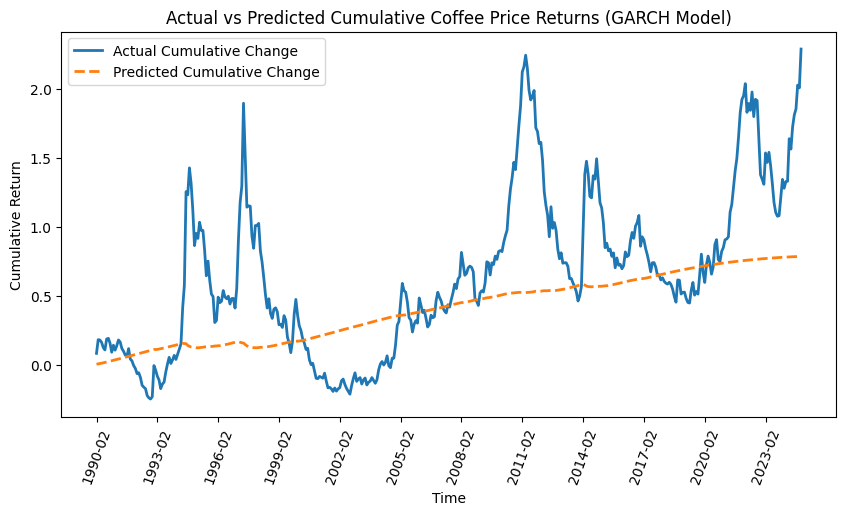

In [818]:
plt.figure(figsize=(10,5))
plt.plot(returns_aligned.index, cumulative_actual, label="Actual Cumulative Change", linewidth=2)
plt.plot(returns_aligned.index, cumulative_predicted, label="Predicted Cumulative Change", linestyle="dashed", linewidth=2)
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(returns_aligned), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Actual vs Predicted Cumulative Coffee Price Returns (GARCH Model)")

# Show plot
plt.show()

In [819]:
print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.011703377137931452
Test MSE: 0.012271830069188635


<div align="center">
  ARDL(1,1) Model
</div>

In [820]:
for column in main_df.columns:
    if "diff" not in column.lower() and "coffee" not in column.lower():
        new_column_name = column.split()[0][:3] + "_diff" if len(column.split()) > 1 else column[:3] + "_diff"
        
        main_df[new_column_name] = main_df[column].diff()
        
        main_df[new_column_name].dropna(inplace=True)

C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df[new_column_name] = main_df[column].diff()
C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df[new_column_name].dropna(inplace=True)
C:\Users\nicol\AppData\Local\Temp\ipykernel_6276\3624867813.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [821]:
y = main_df["coffee_diff"].dropna()
X = main_df.drop("coffee_diff", axis=1).dropna()

In [822]:
train_size = int(len(main_df) * 0.8)
train_data = main_df[:train_size].dropna()
test_data = main_df[train_size:].dropna()

X_train = train_data[X.columns]
X_test = test_data[X.columns]

y_train = train_data[y.name]
y_test = test_data[y.name]

lags = 1

X_train_lagged = pd.concat([X_train.shift(i) for i in range(1, lags + 1)], axis=1).dropna()
X_test_lagged = pd.concat([X_test.shift(i) for i in range(1, lags + 1)], axis=1).dropna()

y_train_lagged = y_train.iloc[lags:]
y_test_lagged = y_test.iloc[lags:]

X_lagged = pd.concat([X_train_lagged, X_test_lagged], axis=0)
y_lagged = pd.concat([y_train_lagged, y_test_lagged], axis=0)

X_lagged = sm.add_constant(X_lagged)

model = sm.OLS(y_lagged, X_lagged)
model_fit = model.fit()

print(model_fit.summary())

train_predictions = model_fit.predict(sm.add_constant(X_train_lagged))
test_predictions = model_fit.predict(sm.add_constant(X_test_lagged))

train_mse = mean_squared_error(y_train_lagged, train_predictions)
test_mse = mean_squared_error(y_test_lagged, test_predictions)

predicted_returns = np.concatenate([train_predictions, test_predictions])

returns_aligned = pd.concat([y_train_lagged, y_test_lagged])
predicted_returns_aligned = pd.Series(predicted_returns, index=returns_aligned.index)

cumulative_actual = returns_aligned.cumsum()
cumulative_predicted = predicted_returns_aligned.cumsum()

                            OLS Regression Results                            
Dep. Variable:            coffee_diff   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     4.917
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           1.93e-20
Time:                        17:11:47   Log-Likelihood:                 444.30
No. Observations:                 415   AIC:                            -780.6
Df Residuals:                     361   BIC:                            -563.1
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

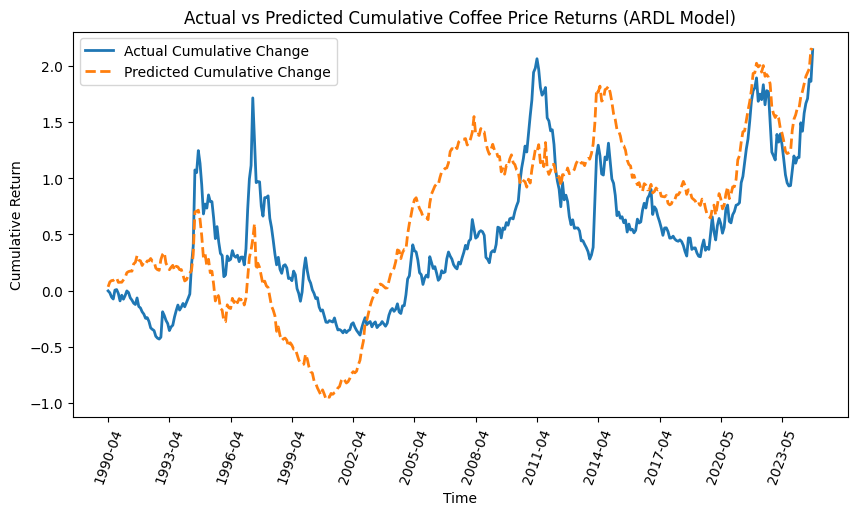

In [823]:
plt.figure(figsize=(10,5))
plt.plot(returns_aligned.index, cumulative_actual, label="Actual Cumulative Change", linewidth=2)
plt.plot(returns_aligned.index, cumulative_predicted, label="Predicted Cumulative Change", linestyle="dashed", linewidth=2)
plt.legend()

tick_interval = 36
plt.xticks(range(0, len(returns_aligned), tick_interval), rotation=70)

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Actual vs Predicted Cumulative Coffee Price Returns (ARDL Model)")

plt.show()

In [824]:
print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 0.006818444780733721
Test MSE: 0.00712886653723148
